In [2]:
import os
import random
import numpy as np
from numpy import genfromtxt
import pandas as pd
import math
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import sys
import shutil
import warnings

In [3]:
if 'google.colab' in str(get_ipython()):

  # To run in Gogogle Colab
  # You have to create a folder IFT6759 in your google drive 
  # and put all content of the folder ift-6759-forecast-project 

  #@title Mount your Google Drive

  %matplotlib inline
  %load_ext autoreload
  %autoreload 2

  from google.colab import drive
  #drive.mount('/content/gdrive')
  drive.mount("/content/gdrive", force_remount=True)

  folder = "/content/gdrive/MyDrive/IFT6759" #@param {type:"string"}
  !ln -Ts $folder /content/IFT6759 2> /dev/null

  # Add the assignment folder to Python path
  if '/content/IFT6759' not in sys.path:
      sys.path.insert(0, '/content/IFT6759')

  sys.path.insert(0,'/content/gdrive/MyDrive/IFT6759/functions')
  import utils
  sys.path.insert(0,'/content/gdrive/MyDrive/IFT6759/models')
  import SUNSET

else:

  import models.SUNSET as SUNSET
  import functions.utils as utils


Mounted at /content/gdrive


In [4]:
# Create device to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# set RNG

seed = 0
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if device.type=='cuda':
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [6]:
# define folder location

dir_path = os.getcwd()

if 'google.colab' in str(get_ipython()):
  dir_path = os.path.join(dir_path, "gdrive/MyDrive/IFT6759")

data_folder = os.path.join(dir_path, "data")
model_folder = os.path.join(dir_path, "model")

#define file location

images_trainval_path = os.path.join(data_folder,'images_trainval.npy')
pv_log_trainval_path = os.path.join(data_folder,'pv_log_trainval.npy')
datetime_trainval_path = os.path.join(data_folder,'datetime_trainval.npy')

images_test_path = os.path.join(data_folder,'images_test.npy')
pv_log_test_path = os.path.join(data_folder,'pv_log_test.npy')
datetime_test_path = os.path.join(data_folder,'datetime_test.npy')


In [7]:
# get weather classification

# train

w_class_train_path = os.path.join(data_folder,'train_label_3_classes.csv')
w_class_train = pd.read_csv(w_class_train_path)

index_train_sunny = np.where(w_class_train == 'sunny')[0]
index_train_cloudy = np.where(w_class_train == 'cloudy')[0]
index_train_overcast = np.where(w_class_train == 'overcast')[0]

#test
w_class_test_path = os.path.join(data_folder,'test_label_3_classes.csv')
w_class_test = pd.read_csv(w_class_test_path)

index_test_sunny = np.where(w_class_test == 'sunny')[0]
index_test_cloudy = np.where(w_class_test == 'cloudy')[0]
index_test_overcast = np.where(w_class_test == 'overcast')[0]


In [8]:
# load PV output and images for the trainval set

pv_log_trainval = np.load(pv_log_trainval_path)
images_trainval = np.load(images_trainval_path)
images_trainval = images_trainval.reshape(images_trainval.shape[0],3,64,64)
datetimes_trainval = np.load(datetime_trainval_path, allow_pickle=True)

# load PV output and images for the test set

pv_log_test = np.load(pv_log_test_path)
images_test = np.load(images_test_path)
images_test = images_test.reshape(images_test.shape[0],3,64,64)
datetimes_test = np.load(datetime_test_path, allow_pickle=True)


In [9]:
class ImageData(Dataset):
    
    def __init__(self, inputs, labels):
        'Initialization'
        self.inputs = inputs
        self.labels = labels


    def __len__(self):
        'Denotes the total number of samples'
        return self.inputs.shape[0]

    def __getitem__(self, index):
        'Generates one sample of data'

        X = self.inputs[index].clone().detach()
        y = self.labels[index].clone().detach()
        
        return X, y

In [10]:
# Create Datasets

train_data_sunny = ImageData(torch.tensor(images_trainval[index_train_sunny]), torch.tensor(pv_log_trainval[index_train_sunny]))
train_data_cloudy = ImageData(torch.tensor(images_trainval[index_train_cloudy]), torch.tensor(pv_log_trainval[index_train_cloudy]))
train_data_overcast = ImageData(torch.tensor(images_trainval[index_train_overcast]), torch.tensor(pv_log_trainval[index_train_overcast]))

test_data_sunny = ImageData(torch.tensor(images_test[index_test_sunny]), torch.tensor(pv_log_test[index_test_sunny]))
test_data_cloudy = ImageData(torch.tensor(images_test[index_test_cloudy]), torch.tensor(pv_log_test[index_test_cloudy]))
test_data_overcast = ImageData(torch.tensor(images_test[index_test_overcast]), torch.tensor(pv_log_test[index_test_overcast]))

In [11]:
# Create Dataloaders

batch_size = 128
batch_size_eval = 128

# train dataloaders

n_valid = 0 # if use valid dataloaders, define a % of train dataset

train_loader_sunny = DataLoader(
    train_data_sunny,
    batch_size=batch_size,
    #sampler=SubsetRandomSampler(indices[:-n_valid]), # use if create valid dataloaders
    num_workers=1
)

train_loader_cloudy = DataLoader(
    train_data_cloudy,
    batch_size=batch_size,
    #sampler=SubsetRandomSampler(indices[:-n_valid]), # use if create valid dataloaders
    num_workers=1
)

train_loader_overcast = DataLoader(
    train_data_overcast,
    batch_size=batch_size,
    #sampler=SubsetRandomSampler(indices[:-n_valid]), # use if create valid dataloaders
    num_workers=1
)


# test dataloaders


test_loader_sunny = DataLoader(
    test_data_sunny,
    batch_size=batch_size_eval,
    num_workers=1
)

test_loader_cloudy = DataLoader(
    test_data_cloudy,
    batch_size=batch_size_eval,
    num_workers=1
)

test_loader_overcast = DataLoader(
    test_data_overcast,
    batch_size=batch_size_eval,
    num_workers=1
)

In [12]:
# check # instances of sunny, cloudy, overcast
np.shape(index_test_sunny), np.shape(index_test_cloudy), np.shape(index_test_overcast)

((2364,), (4470,), (3076,))

In [13]:
### We initialize the parameters

num_epochs = 20
learning_rate = 3e-6

In [14]:
import importlib
importlib.reload(utils)

<module 'utils' from '/content/gdrive/MyDrive/IFT6759/functions/utils.py'>

In [ ]:
# Sunny predictor

model_sunny = SUNSET.SUNSET_Sunny().to(device)

loss_fn_sunny = nn.MSELoss(reduction='sum')
optimizer_sunny = optim.Adam(model_sunny.parameters() , lr=learning_rate)
Train_losses_sunny = []
Test_losses_sunny = []

train_sunny_size = len(train_loader_sunny.dataset)
test_sunny_size = len(test_loader_sunny.dataset)

for epoch in range(num_epochs):
    
    l_train, l_test =  utils.train_test(model_sunny, train_loader_sunny,test_loader_sunny, optimizer_sunny, loss_fn_sunny, device)      
    
    Train_losses_sunny.append(math.sqrt(l_train/train_sunny_size))
    Test_losses_sunny.append(math.sqrt(l_test/test_sunny_size))
    #Train_losses_sunny.append(math.sqrt(l_train/len(train_loader_sunny)))
    #Test_losses_sunny.append(math.sqrt(l_test/len(test_loader_sunny)))
    
    print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses_sunny[epoch]) + 
          ' test loss: ' + str(Test_losses_sunny[epoch])     ) 

epoch: 0 train loss: 9.084073261906298 test loss: 8.189876682730427
epoch: 1 train loss: 7.048284603031882 test loss: 7.065557908261842
epoch: 2 train loss: 6.077775221471489 test loss: 6.506124961882423
epoch: 3 train loss: 5.566002525482941 test loss: 6.107858308610983
epoch: 4 train loss: 5.1991718896204775 test loss: 5.765726665869916
epoch: 5 train loss: 4.890837816245382 test loss: 5.458146318366656
epoch: 6 train loss: 4.619478537389153 test loss: 5.180145143217804
epoch: 7 train loss: 4.379493188715772 test loss: 4.930016427243178
epoch: 8 train loss: 4.16935847021825 test loss: 4.707037162947119
epoch: 9 train loss: 3.988245076404669 test loss: 4.510472562801202
epoch: 10 train loss: 3.8348293236248576 test loss: 4.3389181909348915
epoch: 11 train loss: 3.7069977568854102 test loss: 4.190483067521309
epoch: 12 train loss: 3.6018667105738635 test loss: 4.062807083489621


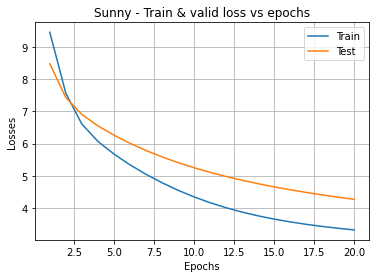

In [ ]:
x = np.arange(1, num_epochs + 1)
plt.plot(x, Train_losses_sunny, label='Train')
plt.plot(x, Test_losses_sunny, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Sunny - Train & valid loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Cloudy predictor

model_cloudy = SUNSET.SUNSET_Cloudy().to(device)

loss_fn_cloudy = nn.MSELoss()
optimizer_cloudy = optim.Adam(model_cloudy.parameters() , lr=learning_rate)
Train_losses_cloudy = []
Test_losses_cloudy = []

train_cloudy_size = len(train_loader_cloudy.dataset)
test_cloudy_size = len(test_loader_cloudy.dataset)

for epoch in range(num_epochs):
    
    l_train, l_test =  utils.train_test(model_cloudy, train_loader_cloudy, test_loader_cloudy, optimizer_cloudy, loss_fn_cloudy, device)      
    
    Train_losses_cloudy.append(math.sqrt(l_train/train_cloudy_size))
    Test_losses_cloudy.append(math.sqrt(l_test/test_cloudy_size))
    
    print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses_cloudy[epoch]) + 
          ' test loss: ' + str(Test_losses_cloudy[epoch])     ) 

epoch: 0 train loss: 1.050592193796968 test loss: 0.9939325048342287
epoch: 1 train loss: 0.8488325134968259 test loss: 0.8347669996650675
epoch: 2 train loss: 0.6810735023807336 test loss: 0.7085680036616928
epoch: 3 train loss: 0.5511594096946633 test loss: 0.6108234487354388
epoch: 4 train loss: 0.4529351758587716 test loss: 0.5363464717409325
epoch: 5 train loss: 0.3802727045855565 test loss: 0.48063616504086193
epoch: 6 train loss: 0.32783299351310025 test loss: 0.4397837632816844
epoch: 7 train loss: 0.29092316475050295 test loss: 0.4105488548308778
epoch: 8 train loss: 0.26553404543313913 test loss: 0.39025978588775806
epoch: 9 train loss: 0.2482937517079025 test loss: 0.37676900039599986
epoch: 10 train loss: 0.2365315529437665 test loss: 0.36831663453177016
epoch: 11 train loss: 0.22826240920170626 test loss: 0.3634881278730551
epoch: 12 train loss: 0.22213368843024836 test loss: 0.36117400214475415
epoch: 13 train loss: 0.21729567984251955 test loss: 0.3604905920998729
epoch:

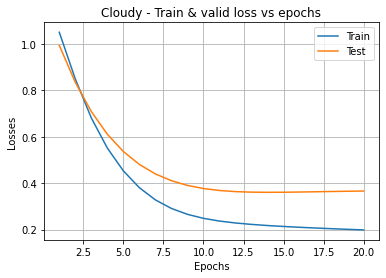

In [ ]:
x = np.arange(1, num_epochs + 1)
plt.plot(x, Train_losses_cloudy, label='Train')
plt.plot(x, Test_losses_cloudy, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Cloudy - Train & valid loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Overcast predictor

model_overcast = SUNSET.SUNSET_Overcast().to(device)

loss_fn_overcast = nn.MSELoss()
optimizer_overcast = optim.Adam(model_overcast.parameters() , lr=learning_rate)
Train_losses_overcast = []
Test_losses_overcast = []

train_overcast_size = len(train_loader_overcast.dataset)
test_overcast_size = len(test_loader_overcast.dataset)

for epoch in range(num_epochs):
    
    l_train, l_test =  utils.train_test(model_overcast, train_loader_overcast, test_loader_overcast, optimizer_overcast, loss_fn_overcast, device)      
    
    Train_losses_overcast.append(math.sqrt(l_train/train_overcast_size))
    Test_losses_overcast.append(math.sqrt(l_test/test_overcast_size))

    
    print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses_overcast[epoch]) + 
          ' test loss: ' + str(Test_losses_overcast[epoch])     ) 

epoch: 0 train loss: 0.7244777838896143 test loss: 0.518327046124913
epoch: 1 train loss: 0.44714841792720844 test loss: 0.3775032545739558
epoch: 2 train loss: 0.34978498392711016 test loss: 0.36121923075213364
epoch: 3 train loss: 0.3184902079871227 test loss: 0.374129310461734
epoch: 4 train loss: 0.30533507043408736 test loss: 0.38159650465655215
epoch: 5 train loss: 0.29582698744450103 test loss: 0.3852722059707816
epoch: 6 train loss: 0.2877688834168934 test loss: 0.38528796422497935
epoch: 7 train loss: 0.27945940223138244 test loss: 0.3863757269162207
epoch: 8 train loss: 0.2737837684138216 test loss: 0.3868083308696996
epoch: 9 train loss: 0.2670708282766318 test loss: 0.3865413501896709
epoch: 10 train loss: 0.26137667068079423 test loss: 0.385667021441328
epoch: 11 train loss: 0.25644916660585887 test loss: 0.3828399794994201
epoch: 12 train loss: 0.2524971042814296 test loss: 0.38291352865359135
epoch: 13 train loss: 0.24882682360713285 test loss: 0.38198212679058896
epoch:

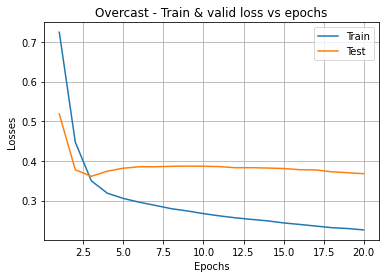

In [ ]:
x = np.arange(1, num_epochs + 1)
plt.plot(x, Train_losses_overcast, label='Train')
plt.plot(x, Test_losses_overcast, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Overcast - Train & valid loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Test Base SUNSET with complete dataset

train_data = ImageData(torch.tensor(images_trainval), torch.tensor(pv_log_trainval))
test_data = ImageData(torch.tensor(images_test), torch.tensor(pv_log_test))

# Create Dataloaders

batch_size = 128
batch_size_eval = 128

# dataloaders

n_valid = 0 # if use valid dataloaders, define a % of train dataset

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    #sampler=SubsetRandomSampler(indices[:-n_valid]), # use if create valid dataloaders
    num_workers=1
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size_eval,
    num_workers=1
)

# train / test

model_base = SUNSET.SUNSETBase().to(device)

loss_fn = nn.MSELoss(reduction = 'sum')
optimizer = optim.Adam(model_base.parameters() , lr=learning_rate)
Train_losses = []
Test_losses = []

train_size = len(train_loader.dataset)
test_size = len(test_loader.dataset)

for epoch in range(num_epochs):
    
    l_train, l_test =  utils.train_test(model_base, train_loader,test_loader, optimizer, loss_fn, device)      
    
    Train_losses.append(math.sqrt(l_train/train_size))
    Test_losses.append(math.sqrt(l_test/test_size))

    print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[epoch]) + 
          ' test loss: ' + str(Test_losses[epoch])     ) 

epoch: 0 train loss: 7.845236020236918 test loss: 6.896883915859922
epoch: 1 train loss: 3.555875738994202 test loss: 6.588203893754925
epoch: 2 train loss: 3.332238905111014 test loss: 6.338825128295863
epoch: 3 train loss: 3.192292539358361 test loss: 6.186509701909041
epoch: 4 train loss: 3.0680829147074817 test loss: 6.0654681960719845
epoch: 5 train loss: 2.979351274877689 test loss: 5.973779198632501
epoch: 6 train loss: 2.8995298023449054 test loss: 5.9076425262252465
epoch: 7 train loss: 2.828344274876778 test loss: 5.8411388633398005
epoch: 8 train loss: 2.7725345180736145 test loss: 5.825451800021787
epoch: 9 train loss: 2.7141629224290655 test loss: 5.824915544472038
epoch: 10 train loss: 2.6770496176393235 test loss: 5.819100072207445
epoch: 11 train loss: 2.632470010814473 test loss: 5.826748700897624
epoch: 12 train loss: 2.599608263499502 test loss: 5.82732578330171
epoch: 13 train loss: 2.568136360731029 test loss: 5.868079111566612
epoch: 14 train loss: 2.5279827444080

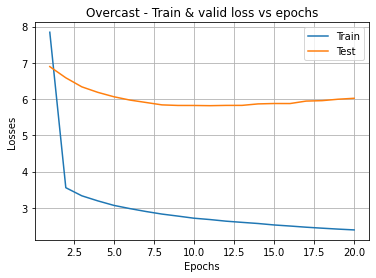

In [ ]:
x = np.arange(1, num_epochs + 1)
plt.plot(x, Train_losses, label='Train')
plt.plot(x, Test_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Overcast - Train & valid loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Loss from the last epoch of each model

Test_losses_sunny[-1], Test_losses_cloudy[-1], Test_losses_overcast[-1]

(4.273060315515332, 0.3659587226556529, 0.367815368069397)

In [ ]:
# overall Loss

Test_loss_class = math.sqrt (
                              ( 
                                Test_losses_sunny[-1]*test_sunny_size + 
                                Test_losses_cloudy[-1]*test_cloudy_size +
                                Test_losses_overcast[-1]*test_overcast_size 
                              ) / (test_sunny_size+test_cloudy_size+test_overcast_size)
                            )

Test_loss_class

1.1395446781475917

In [ ]:
# Save models
'''
model_sunny_path = os.path.join(model_folder,'pred_sunny.pt')    
torch.save(model_sunny.state_dict(), model_sunny_path)

model_cloudy_path = os.path.join(model_folder,'pred_cloudy.pt')    
torch.save(model_cloudy.state_dict(), model_cloudy_path)

model_overcast_path = os.path.join(data_folder,'pred_overcast.pt')    
torch.save(model_overcast.state_dict(), model_overcast_path)
'''